In [1]:
import numpy as np
from scipy import io
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data = []
labels = []
path = "./Raw_data/"
for label in range(5):
    print(label)
    f_path = os.path.join(os.path.join(path, str(label)), "fft_data_final.mat")
    data.append(io.loadmat(f_path)["fft_data_final"])
    labels.extend([label]*data[-1].shape[2])

data = np.concatenate(data, axis=2)
labels = np.array(labels)

0
1
2
3
4


In [3]:
data.shape

(866, 256, 5000)

In [4]:
labels.shape

(5000,)

In [5]:
temp = np.where(data[0, 0, :] != 0)
train_test_data = data[:, :, temp[0]]
train_test_labels = labels[temp[0]]


In [6]:
import matplotlib.pyplot as plt

In [7]:
background_img = np.mean(train_test_data[:, :, 0:200], axis=2)

In [8]:
train_test_labels[450]

2

In [9]:
max_inds = np.unravel_index(np.argsort(train_test_data[:, :, 500] - background_img, axis=None), background_img.shape)

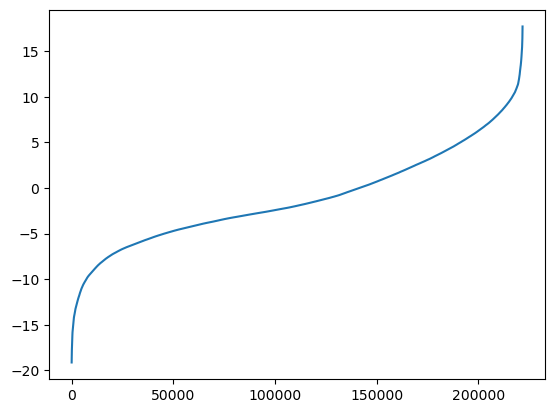

In [10]:
plt.plot(range(866*256), (train_test_data[:, :, 500] - background_img)[max_inds[0], max_inds[1]])

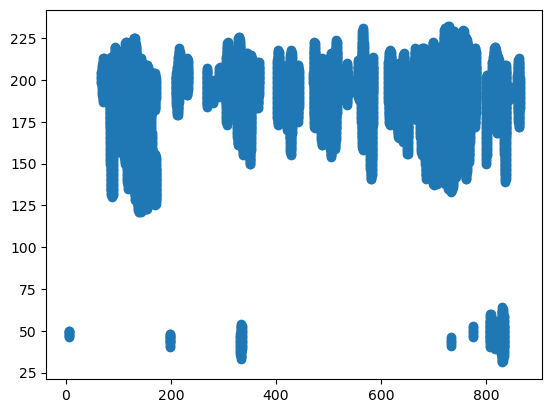

In [11]:
plt.scatter(max_inds[0][-22000:], max_inds[1][-22000:])

In [12]:
train_test_data = train_test_data - background_img[:, :, np.newaxis]

In [14]:
# use cross entropy loss
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).to(torch.int64)
test_labels = torch.from_numpy(test_labels).to(torch.int64)

train_labels = F.one_hot(train_labels, 5)
test_labels = F.one_hot(test_labels, 5)

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



In [15]:
# Run this code for different model types 
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*6*2, 16)
        self.fc2 = nn.Linear(16, 5)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 32*6*2)
        x = torch.relu(self.fc1(x))
        x = self.sm(self.fc2(x))
        return x

# Instantiate the model
model = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_data = []
test_loss_data = [] 
temp_out = 10000 
num_epochs = 100
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        test_loss = criterion(out, test_labels.float())
        print("test loss - {}".format(criterion(out, test_labels.float())))


    train_loss = running_loss / len(train_loader) 
    if (train_loss > temp_out):
        break
    temp_out = train_loss 
    
    # Print statistics
    train_loss_data.append(temp_out)
    test_loss_data.append(test_loss)
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
    
print('Finished Training')


tensor(1.6382, grad_fn=<DivBackward1>)
tensor(1.5921, grad_fn=<DivBackward1>)
tensor(1.5892, grad_fn=<DivBackward1>)
tensor(1.4846, grad_fn=<DivBackward1>)
tensor(1.4783, grad_fn=<DivBackward1>)
tensor(1.4735, grad_fn=<DivBackward1>)
tensor(1.4004, grad_fn=<DivBackward1>)
tensor(1.4175, grad_fn=<DivBackward1>)
tensor(1.4294, grad_fn=<DivBackward1>)
tensor(1.3980, grad_fn=<DivBackward1>)
tensor(1.4881, grad_fn=<DivBackward1>)
tensor(1.5098, grad_fn=<DivBackward1>)
tensor(1.5116, grad_fn=<DivBackward1>)
tensor(1.4303, grad_fn=<DivBackward1>)
tensor(1.3861, grad_fn=<DivBackward1>)
tensor(1.4123, grad_fn=<DivBackward1>)
tensor(1.3929, grad_fn=<DivBackward1>)
tensor(1.3427, grad_fn=<DivBackward1>)
tensor(1.3949, grad_fn=<DivBackward1>)
tensor(1.2676, grad_fn=<DivBackward1>)
tensor(1.2693, grad_fn=<DivBackward1>)
tensor(1.3336, grad_fn=<DivBackward1>)
tensor(1.3071, grad_fn=<DivBackward1>)
tensor(1.3809, grad_fn=<DivBackward1>)
tensor(1.3534, grad_fn=<DivBackward1>)


KeyboardInterrupt: 

In [16]:
out = model(test_data)

In [ ]:
pred_labels = torch.argmax(out, axis=1)

In [ ]:
actual_labels = torch.argmax(test_labels, axis=1)

In [ ]:
import seaborn as sns
cf_matrix = confusion_matrix(actual_labels, pred_labels)

s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
for i in range(5):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy


In [ ]:

plt.plot(range(1, len(train_loss_data) + 1), train_loss_data, label='Train Loss')
plt.plot(range(1, len(test_loss_data) + 1), test_loss_data, label='Test Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses over Epochs')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
test_labels.shape

In [ ]:
# see data

In [ ]:
img = None
for i in range(1000):
    fig = plt.figure()
    plt.imshow(train_test_data[:, :, i])
    fig.savefig("./fft_images/{}.png".format(i))
    #plt.draw()

In [ ]:
# people detection (binary)

In [ ]:
from sklearn.model_selection import train_test_split

train_test_labels = train_test_labels.astype(int)
train_test_labels[train_test_labels > 0] = 1
train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).float()
test_labels = torch.from_numpy(test_labels).float()

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



In [ ]:
# people detection 
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*6*2, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 16*6*2)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = x.flatten()
        return x

# Instantiate the model
model = Net()
print(model)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_data = []
test_loss_data = [] 
temp_out = 10000 
num_epochs = 100

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Define the loss function
        inputs, labels = data
        class_weights = torch.tensor([0.2]*32).to("cpu")
        class_weights[labels == 0] = 0.8
        criterion = nn.BCELoss(weight=class_weights)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        test_loss = torch.nn.functional.mse_loss(out, test_labels)
        print("test loss - {}".format(torch.nn.functional.mse_loss(out, test_labels)))

    train_loss = running_loss / len(train_loader) 
    if (train_loss > temp_out):
        break
    temp_out = train_loss 
    
    # Print statistics
    train_loss_data.append(temp_out)
    test_loss_data.append(test_loss)
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

print('Finished Training')


In [ ]:
out = model(test_data)
out[out > 0.5] = 1
out[out < 0.5] = 0
import seaborn as sns
cf_matrix = confusion_matrix(test_labels.detach().numpy(), out.detach().numpy())

s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
true_reps = 0
for i in range(len(cf_matrix)):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy

In [ ]:
plt.plot(range(1, len(train_loss_data) + 1), train_loss_data, label='Train Loss')
plt.plot(range(1, len(test_loss_data) + 1), test_loss_data, label='Test Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses over Epochs')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# from torchvision.utils import save_image
# save_image(model, "model.png")

In [ ]:
out

In [ ]:
test_labels

In [ ]:
# Old data with 0.01 learning rate and limited epochs 
import seaborn as sns
hehe1 = np.array([[ 42,   1],
       [  3, 154]])

cf_matrix = hehe1
s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
true_reps = 0
for i in range(len(cf_matrix)):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy

In [ ]:
# Old data with 0.01 learning rate and limited epochs 
import seaborn as sns
hehe2 = np.array([[43,  0,  0,  0,  0],
       [ 3, 25,  1,  8,  3],
       [ 3,  1, 25,  3,  5],
       [ 0,  1,  0, 33,  2],
       [ 0,  1,  3,  6, 34]])
cf_matrix = hehe2
s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
true_reps = 0
for i in range(len(cf_matrix)):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy